# K-Means Clustering

## Importing the libraries

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

## Importing the dataset

In [266]:
df = pd.read_csv('train.csv')
y = df['price_range']
df = df.drop(['price_range'],axis = 1)

In [275]:
df.shape

(2000, 20)

## Using the elbow method to find the optimal number of clusters

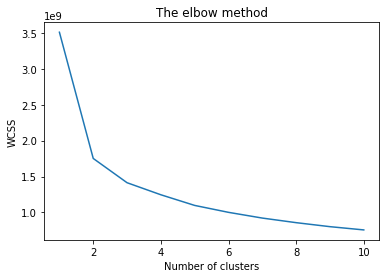

In [267]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#Scaling values
It is necessary, many features are there with different value range, need to scale them within a range 

In [268]:
df_scaled = df
from sklearn.preprocessing import StandardScaler
df_scaled[df_scaled.columns] = StandardScaler().fit_transform(df_scaled)
print(df_scaled.describe())

       battery_power          blue   clock_speed      dual_sim            fc  \
count   2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean    2.149392e-16 -1.243450e-17 -1.545430e-16  8.082424e-17  5.861978e-17   
std     1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min    -1.678817e+00 -9.900495e-01 -1.253064e+00 -1.019184e+00 -9.928904e-01   
25%    -8.804033e-01 -9.900495e-01 -1.007906e+00 -1.019184e+00 -7.624947e-01   
50%    -2.849593e-02 -9.900495e-01 -2.727384e-02  9.811771e-01 -3.017032e-01   
75%     8.575560e-01  1.010051e+00  8.307794e-01  9.811771e-01  6.198797e-01   
max     1.728812e+00  1.010051e+00  1.811412e+00  9.811771e-01  3.384628e+00   

             four_g    int_memory         m_dep     mobile_wt       n_cores  \
count  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean   1.048051e-16 -9.592327e-17 -1.030287e-16  1.278977e-16 -7.727152e-17   
std    1.000250e+00  1.000250e+00  1.00025

# Dimensionality Reduction
Using PCA (Principle Component Analysis) because to plot the datasets in graph, need 2 features maximum, but we have 20 features 

In [269]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

dataset_pca = pd.DataFrame(abs(pca.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)
    
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")


Explained variation per principal component: [0.0837639  0.08109033]
Cumulative variance explained by 2 principal components: 16.49%


       battery_power      blue  clock_speed  dual_sim        fc    four_g  \
PC_1       0.082141  0.009819     0.062788  0.012328  0.564040  0.250150   
PC_2       0.038886  0.032273     0.088062  0.029620  0.377232  0.515369   

      int_memory     m_dep  mobile_wt   n_cores        pc  px_height  \
PC_1    0.081977  0.039707   0.092686  0.005267  0.563464   0.180467   
PC_2    0.017212  0.012017   0.003723  0.022768  0.380503   0.054103   

      px_width       ram      sc_h      sc_w  talk_time   three_g  \
PC_1  0.163947  0.010035  0.272557  0.284698   0.071493  0.230346   
PC_2  0.076375  0.063256  0.266055  0.267912   0.077231  0.520457   

      touch_screen      wifi  
PC_1       0.02058  0.021391  
PC_2       0.00569  0.054344  

*************** Most important features *************************
As per PC 1:
 fc    0.564040
pc    0.563464
Name: 

#Hyper parameter
Tuning to select the best from all the parameters on the basis of silhouette_score.

param data: dimensionality reduced data after applying PCA

return: best number of clusters for the model (used for KMeans n_clusters)
    

In [270]:
def kmean_hyper_param_tuning(data):
   
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]

    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []

    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p

        ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores

        print('Parameter:', p, 'Score', ss)

        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()

    return best_grid['n_clusters']

## Training the K-Means model on the transformed dataset

Parameter: {'n_clusters': 2} Score 0.06771623890102013
Parameter: {'n_clusters': 3} Score 0.06544040768787353
Parameter: {'n_clusters': 4} Score 0.058528149258327944
Parameter: {'n_clusters': 5} Score 0.05374813302706155
Parameter: {'n_clusters': 10} Score 0.04661981960588801
Parameter: {'n_clusters': 15} Score 0.046891601784210764
Parameter: {'n_clusters': 20} Score 0.046149071455133264
Parameter: {'n_clusters': 25} Score 0.04582490039540252
Parameter: {'n_clusters': 30} Score 0.048019432752840346
Parameter: {'n_clusters': 35} Score 0.049364347374170316
Parameter: {'n_clusters': 40} Score 0.049483399566872324


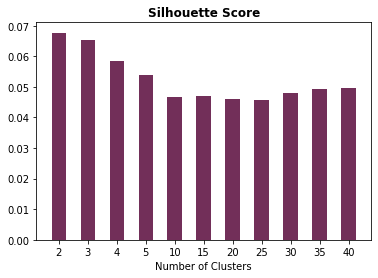

optimum num of clusters = 2


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [276]:
optimum_num_clusters = kmean_hyper_param_tuning(df_scaled)
print("optimum num of clusters =", optimum_num_clusters)

kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

## Visualising the clusters

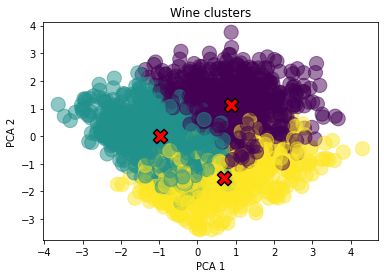

In [277]:
x = pca_result[:, 0]
y = pca_result[:, 1]

plt.scatter(x, y, c=kmeans.labels_, alpha=0.5, s=200)  # plot different colors per cluster
plt.title('Wine clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

plt.show()